(tskit_metadata_vignette)=

# Working with data in tskit format

This vignette discusses how to process simulations stored in a {class}`tskit.TreeSequence`.
A main goal of this vignette is to describe how to access data from the forward simulation stored as metadata in the tree sequence.

This example will be fairly rich in terms of features:

1. We simulate a model of one deme splitting into two.
2. We will record ancient samples from both demes after the split.
3. We initialize our population with a simulation from `msprime`.
4. We will have selected mutations from `fwdpy11` and neutral mutations from `msprime` in our tree sequence.

## Setting up a model

In order to have data to analyze, we need to simulate some.
We will simulate the following demographic model:

In [1]:
yaml="""
description: Two deme model with migration and size changes.
time_units: generations
demes:
- name: ancestral
  description: ancestral deme, two epochs
  epochs:
  - {end_time: 50, start_size: 100}
- name: deme1
  description: child 1
  epochs:
  - {start_size: 25, end_size: 25, end_time: 0}
  ancestors: [ancestral]
- name: deme2
  description: child 2
  epochs:
  - {start_size: 75, end_size: 75, end_time: 0}
  ancestors: [ancestral]
migrations:
- {demes: [deme1, deme2], rate: 1e-3}
"""

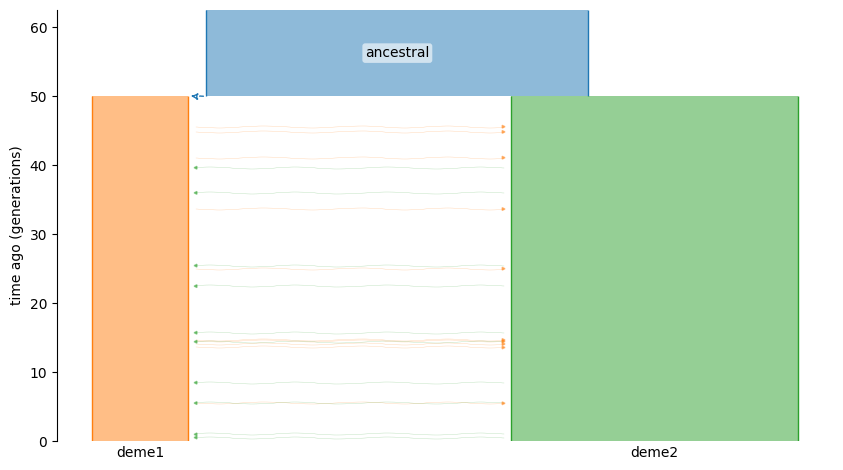

In [2]:
import demes
import demesdraw

graph = demes.loads(yaml)
demesdraw.tubes(graph);

(`graph` is a {class}`demes.Graph`.)

## The forward simulation parameters

In [3]:
import fwdpy11
import msprime
import numpy as np

We will record all individuals in the entire (meta) population after a specific time:

In [4]:
class Recorder(object):
    def __init__(self, when):
        self.when = when

    def __call__(self, pop, sampler):
        if pop.generation >= self.when:
            sampler.assign(np.arange(pop.N))

Set up some general parameters about the "genome":

In [5]:
RHO = 1000. # 4 * ancestral N * r
L = 1000 # Genome length
Nref = graph.demes[0].epochs[0].start_size # Ancestral population size
RECRATE = RHO / 4 / Nref

Will will use a multivariate lognormal distribution of effect sizes.
We have to consider the effect sizes in three different demes:

* The ancestor (deme ID 0)
* Derived deme 1 (deme ID 1)
* Derived deme 2 (deme ID 2)

The goal here is to model a population split such that derived deme 1 represent the continuation of the ancestral population and derived deme 2 is a new deme.
Thus, we want the effect sizes of mutations to be the same in ancestral deme and derived deme 1.
To do this, we need to set our covariance matrix to have a perfect correlation between IDs (indexes) 0 and 1.
However, we cannot use an off-diagonal value exactly equal to 1, else the Cholesky decomposition that is needed to generate deviates will fail.
Our solution is to use off-diagonal values very very close to 1:

In [6]:
vcov = np.identity(3)
vcov[0,1] = 1-np.finfo(np.float64).eps
vcov[1,0] = 1-np.finfo(np.float64).eps
mvdes = fwdpy11.mvDES(
        fwdpy11.LogNormalS.mv(0, L, 1, scaling=-2*Nref),
        np.zeros(3),
        vcov,
    )

The rest is standard.
We will generate the model from a {class}`demes.Graph`:

In [7]:
demog = fwdpy11.discrete_demography.from_demes(graph, burnin=1)

Set up the parameters dictionary:

In [8]:
pdict = {
    'nregions': [],
    'sregions': [mvdes],
    'recregions': [fwdpy11.PoissonInterval(0, L, RECRATE, discrete=True)],
    'rates': (0., 1e-3, None),
    'gvalue': fwdpy11.Multiplicative(ndemes=3, scaling=2.0),
    'demography': demog,
    'simlen': demog.metadata['total_simulation_length'],
    }

params = fwdpy11.ModelParams(**pdict)

Finally, we initialize a population using output from `msprime`, evolve it, and convert the data to `tskit` format:

In [9]:
initial_history = msprime.sim_ancestry(
    samples = 2 * Nref,
    population_size = Nref,
    random_seed = 12345,
    recombination_rate = RECRATE / L,
    discrete_genome = True,
    sequence_length = L,
    model = [
        msprime.DiscreteTimeWrightFisher(duration=int(0.1 * Nref)),
        msprime.StandardCoalescent(),
    ],
)

pop = fwdpy11.DiploidPopulation.create_from_tskit(initial_history)

rng = fwdpy11.GSLrng(54321)

fwdpy11.evolvets(rng, pop, params,
                 recorder=Recorder(when=demog.metadata["burnin_time"] + 1),
                 simplification_interval=100,
                 suppress_table_indexing=True)

ts = pop.dump_tables_to_tskit(demes_graph=graph)

Now that we have some data, let's look at how the `fwdpy11` mutation and individual information got encoded as `tskit` metadata!

## Exploring the mutation metadata

By default, the metadata decode as a {class}`dict`:

In [10]:
for m in ts.mutations():
    print(m.metadata)

{'esizes': [-0.014492203005332261, -0.014492202900161096, -0.024115144535079742], 'h': 1.0, 'heffects': [1.0, 1.0, 1.0], 'key': 6, 'label': 0, 'neutral': False, 'origin': 149, 's': 0.0}
{'esizes': [-0.0009325855351348806, -0.0009325855528507015, -0.0035521384311082405], 'h': 1.0, 'heffects': [1.0, 1.0, 1.0], 'key': 5, 'label': 0, 'neutral': False, 'origin': 142, 's': 0.0}
{'esizes': [-0.007951665402753664, -0.007951665285224932, -0.0020371061917801472], 'h': 1.0, 'heffects': [1.0, 1.0, 1.0], 'key': 4, 'label': 0, 'neutral': False, 'origin': 137, 's': 0.0}
{'esizes': [-0.002834643757547703, -0.002834643826676666, -0.005834938756565091], 'h': 1.0, 'heffects': [1.0, 1.0, 1.0], 'key': 2, 'label': 0, 'neutral': False, 'origin': 135, 's': 0.0}
{'esizes': [-0.0005384173906984983, -0.0005384173856761126, -0.0012702803065279323], 'h': 1.0, 'heffects': [1.0, 1.0, 1.0], 'key': 3, 'label': 0, 'neutral': False, 'origin': 136, 's': 0.0}
{'esizes': [-0.0016351206854282236, -0.001635120719087197, -0.0

We can call {func}`fwdpy11.tskit_tools.decode_mutation_metadata` to convert the `dict` to a {class}`fwdpy11.Mutation`.  Thus function returns a {class}`list` because it can be accessed using a {class}`slice`:

In [11]:
m = fwdpy11.tskit_tools.decode_mutation_metadata(ts, 0)
type(m[0])

fwdpy11._fwdpy11.Mutation

With no arguments, all metadata are converted to the `Mutation` type:

In [12]:
for m in fwdpy11.tskit_tools.decode_mutation_metadata(ts):
    print(m.esizes)

[-0.0144922  -0.0144922  -0.02411514]
[-0.00093259 -0.00093259 -0.00355214]
[-0.00795167 -0.00795167 -0.00203711]
[-0.00283464 -0.00283464 -0.00583494]
[-0.00053842 -0.00053842 -0.00127028]
[-0.00163512 -0.00163512 -0.00504712]
[-0.00071462 -0.00071462 -0.00311322]


:::{note}
For simulations *without* multivariate mutation effects, the metadata will **not** have the `heffects` and `esizes` fields.
When converted to a {class}`fwdpy11.Mutation`, the object will contain empty vectors.
:::

### Adding mutation with `msprime`.

Mutations generated by `fwdpy11` contain metadata, allowing you to get their effect sizes, etc..
When we add mutations to the tree sequence with {func}`msprime.sim_mutations`, the new mutation table rows have *no metadata*.

Let's mutate a copy of our tree sequence.
We will apply a binary, infinite-site model to add neutral mutations:

In [13]:
tscopy = msprime.sim_mutations(ts.tables.tree_sequence(), rate=RECRATE / L, model=msprime.BinaryMutationModel(), discrete_genome=False, random_seed=615243)
print("Our original number of mutations =", ts.num_mutations)
print("Our new number of mutations =", tscopy.num_mutations)

Our original number of mutations = 7
Our new number of mutations = 33747


In [14]:
metadata_is_none = 0
for i in tscopy.mutations():
    if i.metadata is None:
        metadata_is_none += 1

assert metadata_is_none == tscopy.num_mutations - ts.num_mutations
# mut be true because we asked for an "infinite-sites" mutation scheme
assert metadata_is_none == tscopy.num_sites - ts.num_mutations

## Exploring the individual metadata

As with mutations, individual metadata automatically decode to {class}`dict`:

In [15]:
print(ts.individual(0).metadata)
print(type(ts.individual(0).metadata))

{'deme': 1, 'e': 0.0, 'g': 1.0, 'geography': [0.0, 0.0, 0.0], 'label': 0, 'nodes': [0, 1], 'parents': [10, 8], 'sex': 0, 'w': 1.0}
<class 'dict'>


It is often more efficient to decode the data into {class}`fwdpy11.tskit_tools.DiploidMetadata` (which is an `attrs`-based analog to {class}`fwdpy11.DiploidMetadata`).
As with mutation metadata, {func}`fwdpy11.tskit_tools.decode_individual_metadata` returns a list:

In [16]:
fwdpy11.tskit_tools.decode_individual_metadata(ts, 0)

[DiploidMetadata(g=1.0, e=0.0, w=1.0, sex=0, deme=1, label=0, alive=True, preserved=False, first_generation=False, parents=[10, 8], geography=[0.0, 0.0, 0.0], nodes=[0, 1])]

In [17]:
print(type(fwdpy11.tskit_tools.decode_individual_metadata(ts, 0)[0]))

<class 'fwdpy11.tskit_tools.metadata.DiploidMetadata'>


The main difference between this Python class and its C++ analog is that the former contains several fields that decode the `flags` column of the individual table.
See {ref}`here <tskit_tools>` for details.


## Traversing all time points for which individuals exist

The example simulation preserves individuals at many different time points.
Use {func}`fwdpy11.tskit_tools.iterate_timepoints_with_individuals` to automate iterating over each time point:

In [18]:
import pandas as pd
pd.set_option("display.max_rows", 11)

times = []
num_nodes = []
len_metadata = []
for time, nodes, metadata in fwdpy11.tskit_tools.iterate_timepoints_with_individuals(ts, decode_metadata=True):
    times.append(time)
    num_nodes.append(len(nodes))
    len_metadata.append(len(metadata))

df = pd.DataFrame({"time": times, "num_nodes": num_nodes, "num_metadata_objects": len_metadata})
df

,time,num_nodes,num_metadata_objects
0,49.0,200,100
1,48.0,200,100
2,47.0,200,100
3,46.0,200,100
4,45.0,200,100
...,...,...,...
45,4.0,200,100
46,3.0,200,100
47,2.0,200,100
48,1.0,200,100
